# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import re

from sklearn.externals import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans,MiniBatchKMeans
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from DataImputer import DataFrameImputer


# magic word for  producing visualizations in notebook
%matplotlib inline
pd.set_option("display.max_columns", 400)



/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('arvato_data/Udacity_AZDIAS_052018.csv', sep=';',low_memory=False)
customers = pd.read_csv('arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/Users/admin/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Initial Exploration and Understanding Features


In [3]:
azdias.shape

(891221, 366)

In [4]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [5]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [6]:
customers.CUSTOMER_GROUP.unique()

array(['MULTI_BUYER', 'SINGLE_BUYER'], dtype=object)

In [7]:
df_attr_val = pd.read_excel('DIAS Attributes - Values 2017.xlsx',header=1)

In [8]:
df_attr_val.shape

(2258, 5)

In [9]:
df_attr_val.drop(columns=['Unnamed: 0'],inplace=True)

In [10]:
df_attr_val.head(10)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,NaN,NaN,1,< 30 years
7,NaN,NaN,2,30 - 45 years
8,NaN,NaN,3,46 - 60 years
9,NaN,NaN,4,> 60 years


In [11]:
df_attr_val.isnull().sum(axis = 0)

Attribute      1944
Description    1907
Value             0
Meaning          11
dtype: int64

<b>The above dataframe represents the values for attributes  and meanings for those values. This seems to be an important information which can be used during segmentation. I will try to get the Information Level as well for the attributes from the DIAS Information Levels - Attributes 2017.xlsx file and also will do a forward fill to fill up the NaN values</b>

In [12]:
# forward fill the row-wise missing values
df_attributes_val = df_attr_val.copy()
df_attributes_val[['Attribute', 'Description']] = \
            df_attr_val[[ 'Attribute','Description']].ffill()


In [13]:
df_attributes_val.isnull().sum(axis = 0)

Attribute       0
Description     0
Value           0
Meaning        11
dtype: int64

In [14]:
df_attributes_val.head(10)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,age classification through prename analysis,1,< 30 years
7,ALTERSKATEGORIE_GROB,age classification through prename analysis,2,30 - 45 years
8,ALTERSKATEGORIE_GROB,age classification through prename analysis,3,46 - 60 years
9,ALTERSKATEGORIE_GROB,age classification through prename analysis,4,> 60 years


<h2> Digging more into Attributes

In [15]:
df_attr_level = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx',header=1)

In [16]:
df_attr_level.shape

(313, 5)

In [17]:
df_attr_level.drop(columns=['Unnamed: 0'],inplace=True)

In [18]:
df_attr_level.shape

(313, 4)

In [19]:
df_attr_level.head(10)

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,ANREDE_KZ,gender,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...
5,NaN,FINANZ_SPARER,financial typology: money saver,NaN
6,NaN,FINANZ_VORSORGER,financial typology: be prepared,NaN
7,NaN,FINANZ_ANLEGER,financial typology: investor,NaN
8,NaN,FINANZ_UNAUFFAELLIGER,financial typology: unremarkable,NaN
9,NaN,FINANZ_HAUSBAUER,financial typology: main focus is the own house,NaN


In [20]:
df_attr_level.isnull().sum(axis = 0)

Information level    303
Attribute              0
Description            0
Additional notes     293
dtype: int64

In [21]:
attr_val = set(df_attributes_val.Attribute.unique())

In [22]:
attr_level = set(df_attr_level.Attribute.unique())

In [23]:
attr_val - attr_level

{'BIP_FLAG',
 'D19_BANKEN_ANZ_12',
 'D19_BANKEN_ANZ_24',
 'D19_GESAMT_ANZ_12',
 'D19_GESAMT_ANZ_24',
 'D19_LOTTO_RZ',
 'D19_TELKO_ANZ_12',
 'D19_TELKO_ANZ_24',
 'D19_VERSAND_ANZ_12',
 'D19_VERSAND_ANZ_24',
 'D19_VERSI_ANZ_12',
 'D19_VERSI_ANZ_24',
 'KBA13_CCM_3000',
 'KBA13_CCM_3001'}

In [24]:
attr_level - attr_val

{'ARBEIT',
 'D19_BANKEN_ ANZ_12             D19_BANKEN_ ANZ_24',
 'D19_GESAMT_ANZ_12                                    D19_GESAMT_ANZ_24',
 'D19_TELKO_ ANZ_12                  D19_TELKO_ ANZ_24',
 'D19_VERSAND_ ANZ_12          D19_VERSAND_ ANZ_24',
 'D19_VERSI_ ANZ_12                                       D19_VERSI_ ANZ_24',
 'D19_VERSI_DATUM',
 'D19_VERSI_OFFLINE_DATUM',
 'D19_VERSI_ONLINE_DATUM',
 'EINWOHNER',
 'GKZ',
 'PLZ',
 'PLZ8'}

<b>Going through the features in Attribute Value and Attribute level files and also the customer and azdias dataset, it seems that, we will be needing attribute value dataset more to know about the features and there values. Also we see that the 'unknown' values are treated as class for features and is represented in ordinal form. We can use this values for attributes in case we find NaN values in our dataset. But we will take a call on this only after digging further and checking how many such features in the dataset have unknown values and whether it will be a good option either to remove that feature or go ahead using it as one of the ordinal value.</b>

Next I will be combining the information level and additional information data in one dataframe in order to get more visibility on the feature levels.

In [25]:
df_attr_val_level = pd.merge(left=df_attributes_val, right=df_attr_level[['Attribute','Information level']], on=['Attribute'], how='outer', sort=False)

In [26]:
df_attr_val_level.shape

(2271, 5)

In [27]:
df_attr_val_level[['Attribute','Description','Information level']].drop_duplicates()

,Attribute,Description,Information level
0,AGER_TYP,best-ager typology,NaN
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,Person
11,ALTER_HH,main age within the household,Household
33,ANREDE_KZ,gender,NaN
36,ANZ_HAUSHALTE_AKTIV,number of households in the building,Building
...,...,...,...
2266,PLZ,NaN,NaN
2267,PLZ8,NaN,NaN
2268,ARBEIT,NaN,Community
2269,EINWOHNER,NaN,NaN


<b> I dont see much use of Information Level column as of now. But we will keep and store the df_attr_val_level dataframe so that incase if we decide to replace the NaN values based on the values assigned to unknown or null data from the Attrivute value file</b>

In [28]:
#save the attribute value and description file
with open('attribute_describtion_value.pickle', 'wb') as f:
    pickle.dump(df_attr_val_level, f)

In [29]:
customers.shape

(191652, 369)

In [30]:
attributes_in_metadata = set(df_attr_val_level.Attribute)

In [31]:
len(attributes_in_metadata)

327

In [32]:
set(customers.columns) - attributes_in_metadata

{'AKT_DAT_KL',
 'ALTERSKATEGORIE_FEIN',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'ANZ_KINDER',
 'ANZ_STATISTISCHE_HAUSHALTE',
 'CAMEO_INTL_2015',
 'CJT_KATALOGNUTZER',
 'CJT_TYP_1',
 'CJT_TYP_2',
 'CJT_TYP_3',
 'CJT_TYP_4',
 'CJT_TYP_5',
 'CJT_TYP_6',
 'CUSTOMER_GROUP',
 'D19_BANKEN_DIREKT',
 'D19_BANKEN_GROSS',
 'D19_BANKEN_LOKAL',
 'D19_BANKEN_REST',
 'D19_BEKLEIDUNG_GEH',
 'D19_BEKLEIDUNG_REST',
 'D19_BILDUNG',
 'D19_BIO_OEKO',
 'D19_BUCH_CD',
 'D19_DIGIT_SERV',
 'D19_DROGERIEARTIKEL',
 'D19_ENERGIE',
 'D19_FREIZEIT',
 'D19_GARTEN',
 'D19_HANDWERK',
 'D19_HAUS_DEKO',
 'D19_KINDERARTIKEL',
 'D19_KONSUMTYP_MAX',
 'D19_KOSMETIK',
 'D19_LEBENSMITTEL',
 'D19_LETZTER_KAUF_BRANCHE',
 'D19_LOTTO',
 'D19_NAHRUNGSERGAENZUNG',
 'D19_RATGEBER',
 'D19_REISEN',
 'D19_SAMMELARTIKEL',
 'D19_SCHUHE',
 'D19_SONSTIGE',
 'D19_SOZIALES',
 'D19_TECHNIK',
 'D19_TELKO_MOBILE',
 'D19_TELKO_ONLINE_QUOTE_12',
 'D19_TELKO_REST',
 'D19_TIERARTIKEL',
 'D19_VERSAND_REST',
 'D19_VERSICHERUN

In [33]:
attributes_in_metadata - set(customers.columns)

{'BIP_FLAG',
 'CAMEO_DEUINTL_2015',
 'D19_BANKEN_ ANZ_12             D19_BANKEN_ ANZ_24',
 'D19_BANKEN_DIREKT_RZ',
 'D19_BANKEN_GROSS_RZ',
 'D19_BANKEN_LOKAL_RZ',
 'D19_BANKEN_REST_RZ',
 'D19_BEKLEIDUNG_GEH_RZ',
 'D19_BEKLEIDUNG_REST_RZ',
 'D19_BILDUNG_RZ',
 'D19_BIO_OEKO_RZ',
 'D19_BUCH_RZ',
 'D19_DIGIT_SERV_RZ',
 'D19_DROGERIEARTIKEL_RZ',
 'D19_ENERGIE_RZ',
 'D19_FREIZEIT_RZ',
 'D19_GARTEN_RZ',
 'D19_GESAMT_ANZ_12                                    D19_GESAMT_ANZ_24',
 'D19_HANDWERK_RZ',
 'D19_HAUS_DEKO_RZ',
 'D19_KINDERARTIKEL_RZ',
 'D19_KK_KUNDENTYP',
 'D19_KOSMETIK_RZ',
 'D19_LEBENSMITTEL_RZ',
 'D19_LOTTO_RZ',
 'D19_NAHRUNGSERGAENZUNG_RZ',
 'D19_RATGEBER_RZ',
 'D19_REISEN_RZ',
 'D19_SAMMELARTIKEL_RZ',
 'D19_SCHUHE_RZ',
 'D19_SONSTIGE_RZ',
 'D19_TECHNIK_RZ',
 'D19_TELKO_ ANZ_12                  D19_TELKO_ ANZ_24',
 'D19_TELKO_MOBILE_RZ',
 'D19_TELKO_REST_RZ',
 'D19_TIERARTIKEL_RZ',
 'D19_VERSAND_ ANZ_12          D19_VERSAND_ ANZ_24',
 'D19_VERSAND_REST_RZ',
 'D19_VERSICHERUNGEN_RZ'

It seems D19 features have different name in the metadata files. Lets get it consistent. We will remove RZ from metadata attribute list

In [34]:
df_attr_val_level['Attribute'] = df_attr_val_level['Attribute'] \
                                    .apply(lambda x: re.sub('_RZ', '', x) if 'D19' in x else x)

In [35]:
len(set(customers.columns) - set(df_attr_val_level['Attribute']))

60

In [36]:
for col in azdias.select_dtypes(exclude=['int64','float64']).columns:
    print()
    print(col,' ',df_attr_val_level[df_attr_val_level['Attribute']==col]['Description'].drop_duplicates())
    print(*zip(df_attr_val_level[df_attr_val_level['Attribute']==col]['Value'],df_attr_val_level[df_attr_val_level['Attribute']==col]['Meaning']))


CAMEO_DEU_2015   61    CAMEO classification 2015 - detailled classifi...
Name: Description, dtype: object
('1A', 'Work-Life-Balance') ('1B', 'Wealthy Best Ager') ('1C', 'Successful Songwriter') ('1D', 'Old Nobility') ('1E', 'City Nobility') ('2A', 'Cottage Chic') ('2B', 'Noble Jogger') ('2C', 'Established gourmet') ('2D', 'Fine Management') ('3A', 'Career & Family') ('3B', 'Powershopping Families') ('3C', 'Rural Neighborhood') ('3D', 'Secure Retirement') ('4A', 'Family Starter') ('4B', 'Family Life') ('4C', 'String Trimmer') ('4D', 'Empty Nest') ('4E', 'Golden Ager') ('5A', 'Younger Employees') ('5B', 'Suddenly Family') ('5C', 'Family First') ('5D', 'Stock Market Junkies') ('5E', 'Coffee Rider') ('5F', 'Active Retirement') ('6A', 'Jobstarter') ('6B', 'Petty Bourgeois') ('6C', 'Long-established') ('6D', 'Sportgardener') ('6E', 'Urban Parents') ('6F', 'Frugal Aging') ('7A', 'Journeymen') ('7B', 'Mantaplatte') ('7C', 'Factory Worker') ('7D', 'Rear Window') ('7E', 'Interested Retirees') (

In [37]:
for col in customers.select_dtypes(exclude=['int64','float64']).columns:
    print()
    print(col,' ',df_attr_val_level[df_attr_val_level['Attribute']==col]['Description'].drop_duplicates())
    print(*zip(df_attr_val_level[df_attr_val_level['Attribute']==col]['Value'],df_attr_val_level[df_attr_val_level['Attribute']==col]['Meaning']))


CAMEO_DEU_2015   61    CAMEO classification 2015 - detailled classifi...
Name: Description, dtype: object
('1A', 'Work-Life-Balance') ('1B', 'Wealthy Best Ager') ('1C', 'Successful Songwriter') ('1D', 'Old Nobility') ('1E', 'City Nobility') ('2A', 'Cottage Chic') ('2B', 'Noble Jogger') ('2C', 'Established gourmet') ('2D', 'Fine Management') ('3A', 'Career & Family') ('3B', 'Powershopping Families') ('3C', 'Rural Neighborhood') ('3D', 'Secure Retirement') ('4A', 'Family Starter') ('4B', 'Family Life') ('4C', 'String Trimmer') ('4D', 'Empty Nest') ('4E', 'Golden Ager') ('5A', 'Younger Employees') ('5B', 'Suddenly Family') ('5C', 'Family First') ('5D', 'Stock Market Junkies') ('5E', 'Coffee Rider') ('5F', 'Active Retirement') ('6A', 'Jobstarter') ('6B', 'Petty Bourgeois') ('6C', 'Long-established') ('6D', 'Sportgardener') ('6E', 'Urban Parents') ('6F', 'Frugal Aging') ('7A', 'Journeymen') ('7B', 'Mantaplatte') ('7C', 'Factory Worker') ('7D', 'Rear Window') ('7E', 'Interested Retirees') (

# Lets get into the data now and do some cleaning and exploration

In [38]:
customers.describe(include='all')

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [39]:
azdias.describe(include='all')

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

<b>Most of the columns seems to have values for both customers and azdias dataset. Also for the columns belonging to object type, it seems  there is no missing value information in metadata for Column CAMEO_DEU_2015. Lets see if the data has for this columns have any missing value for it.
We need to treat the missing values for all columns. If the number of missing values are less I will use the value of unknown category for imputing the data else we will remove that column. I will decide this based on some threshold after checking data.

Checking for object types

In [40]:
for col in azdias.select_dtypes(exclude=['int64','float64']).columns:
    #EINGEFUEGT_AM has lot of date values
    if not col == 'EINGEFUEGT_AM':
        print(col)
        print(set(azdias[col].unique()))
        print()

CAMEO_DEU_2015
{nan, '4B', '5A', '8C', 'XX', '5E', '7E', '6A', '1D', '6F', '9A', '6E', '9C', '6D', '5D', '8A', '3A', '4E', '1C', '4C', '3B', '1E', '2A', '4A', '8B', '1B', '5B', '6B', '2C', '5F', '9E', '9D', '7B', '1A', '7A', '2D', '7D', '3D', '6C', '4D', '5C', '8D', '2B', '7C', '3C', '9B'}

CAMEO_DEUG_2015
{nan, '3', '2', '1', '5', '7', '4', '9', 'X', '8', '6'}

CAMEO_INTL_2015
{nan, 'XX', '45', '22', '51', '25', '55', '54', '15', '44', '41', '43', '24', '12', '23', '32', '14', '31', '13', '34', '35', '33', '52'}

D19_LETZTER_KAUF_BRANCHE
{nan, 'D19_ENERGIE', 'D19_WEIN_FEINKOST', 'D19_SCHUHE', 'D19_UNBEKANNT', 'D19_HAUS_DEKO', 'D19_GARTEN', 'D19_FREIZEIT', 'D19_BUCH_CD', 'D19_SONSTIGE', 'D19_BILDUNG', 'D19_BANKEN_LOKAL', 'D19_BEKLEIDUNG_GEH', 'D19_TELKO_MOBILE', 'D19_VERSAND_REST', 'D19_TELKO_REST', 'D19_NAHRUNGSERGAENZUNG', 'D19_BANKEN_DIREKT', 'D19_BANKEN_REST', 'D19_DROGERIEARTIKEL', 'D19_VOLLSORTIMENT', 'D19_VERSICHERUNGEN', 'D19_BEKLEIDUNG_REST', 'D19_LOTTO', 'D19_BANKEN_GROSS', '

In [41]:
cat_cols = []
for col in customers.select_dtypes(exclude=['int64','float64']).columns:
    #EINGEFUEGT_AM has lot of date values
    cat_cols.append(col)
    if not col == 'EINGEFUEGT_AM': #this attribute have lot of values, so skipping
        print(col)
        print(set(customers[col].unique()))
        print()

CAMEO_DEU_2015
{nan, '5A', '4B', '8C', 'XX', '5E', '7E', '6A', '1D', '6F', '9A', '9C', '6E', '6D', '5D', '8A', '3A', '4E', '1C', '4C', '3B', '2A', '1E', '4A', '8B', '5B', '5F', '6B', '2C', '1B', '9E', '9D', '7B', '1A', '7A', '2D', '7D', '3D', '6C', '4D', '5C', '2B', '8D', '7C', '3C', '9B'}

CAMEO_DEUG_2015
{nan, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, '6', '7', '4', 'X', '1', '3', '2', '5', '9', '8'}

CAMEO_INTL_2015
{nan, 'XX', 12.0, 13.0, 14.0, 15.0, '45', '22', 22.0, 23.0, 24.0, 25.0, '25', '51', '55', 31.0, 32.0, 33.0, 34.0, 35.0, '54', '15', 41.0, '44', 43.0, 44.0, 45.0, '41', 51.0, 52.0, '43', 54.0, 55.0, '24', '12', '23', '32', '14', '31', '13', '34', '35', '33', '52'}

D19_LETZTER_KAUF_BRANCHE
{nan, 'D19_ENERGIE', 'D19_WEIN_FEINKOST', 'D19_SCHUHE', 'D19_UNBEKANNT', 'D19_HAUS_DEKO', 'D19_GARTEN', 'D19_BANKEN_LOKAL', 'D19_FREIZEIT', 'D19_BUCH_CD', 'D19_SONSTIGE', 'D19_BILDUNG', 'D19_BEKLEIDUNG_GEH', 'D19_TELKO_MOBILE', 'D19_VERSAND_REST', 'D19_TELKO_REST', 'D19_NAHRUNGSERGAE

<b> As we can see the there are NaN values as well as some values with XX. Also some columns have string as well as numeric value</b>

<b>The column D19_LETZTER_KAUF_BRANCHE, has values which represents the columns in our dataset as well. It seems they are  already label encoded according to the individual categorical values of this features. Lets see the values for it

In [42]:
# Checking if we know what the column means
df_attr_val_level[df_attr_val_level['Attribute']=='D19_LETZTER_KAUF_BRANCHE']

,Attribute,Description,Value,Meaning,Information level


In [43]:
azdias['D19_LETZTER_KAUF_BRANCHE'].value_counts()

D19_UNBEKANNT             195338
D19_VERSICHERUNGEN         57734
D19_SONSTIGE               44722
D19_VOLLSORTIMENT          34812
D19_SCHUHE                 32578
D19_BUCH_CD                28754
D19_VERSAND_REST           26034
D19_DROGERIEARTIKEL        24072
D19_BANKEN_DIREKT          23273
D19_BEKLEIDUNG_REST        21796
D19_HAUS_DEKO              20858
D19_TELKO_MOBILE           14447
D19_ENERGIE                12084
D19_TELKO_REST             11472
D19_BANKEN_GROSS           10550
D19_BEKLEIDUNG_GEH         10272
D19_KINDERARTIKEL           7301
D19_FREIZEIT                7257
D19_TECHNIK                 7002
D19_LEBENSMITTEL            6458
D19_BANKEN_REST             5247
D19_RATGEBER                4931
D19_NAHRUNGSERGAENZUNG      4061
D19_DIGIT_SERV              3577
D19_REISEN                  3122
D19_TIERARTIKEL             2578
D19_SAMMELARTIKEL           2443
D19_HANDWERK                2227
D19_WEIN_FEINKOST           2164
D19_GARTEN                  1646
D19_BANKEN

In [44]:
D19_LKB_Values = list(customers['D19_LETZTER_KAUF_BRANCHE'].unique())

In [45]:
for d19 in D19_LKB_Values:
    if d19 in customers.columns and d19 in df_attr_val_level['Attribute'].unique():
        print("Column and Description and Values")
        print(d19," ",list(df_attr_val_level[df_attr_val_level['Attribute']==d19]['Description'])[0]," ",customers[d19].unique())
        # print("\nValue and Meaning")
        # print(*zip(df_attr_val_level[df_attr_val_level['Attribute']==d19]['Value'],df_attr_val_level[df_attr_val_level['Attribute']==d19]['Meaning']))
    else:
        print("====No column or in metadata info ", d19,"====")
    print("---------------------------------------")

====No column or in metadata info  D19_UNBEKANNT ====
---------------------------------------
Column and Description and Values
D19_BANKEN_GROSS   transactional activity based on the product group BIG BANKS   [0 5 3 6 4 2 1]
---------------------------------------
Column and Description and Values
D19_NAHRUNGSERGAENZUNG   transactional activity based on the product group DIETARY SUPPLEMENTS   [0 5 3 6 7 4 2 1]
---------------------------------------
Column and Description and Values
D19_SCHUHE   transactional activity based on the product group SHOES   [0 3 6 7 2 5 1 4]
---------------------------------------
====No column or in metadata info  D19_BUCH_CD ====
---------------------------------------
Column and Description and Values
D19_DROGERIEARTIKEL   transactional activity based on the product group DRUGSTORES   [0 6 4 3 7 5 2 1]
---------------------------------------
Column and Description and Values
D19_SONSTIGE   transactional activity based on the product group ALL OTHER CATEG

<b>
<li>Most of the values in D19_LETZTER_KAUF_BRANCHE are already encoded for us and represents 
(0, 'no transaction known') (1, 'Multibuyer 0-12 months') (2, 'Doublebuyer 0-12 months') (3, 'Singlebuyer 0-12 months') (4, 'Multi-/Doublebuyer 13-24 months') (5, 'Singlebuyer 13-24 months') (6, 'Buyer > 24 months') (7, 'Prospects > 24 months')
<li> We can drop D19_LETZTER_KAUF_BRANCHE column instead from our dataset  D19_UNBEKANNT and D19_BUCH_CD have no separate column in the dataset and we will either remove the 

In [46]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

# Cleaning and Feature Engineering

In [47]:
azdias_copy = azdias.copy()

In [48]:
customers_copy = customers.copy()

In [49]:
azdias_copy.shape

(891221, 366)

In [50]:
customers_copy.shape

(191652, 369)

In [51]:
plt.rcParams["figure.figsize"] = [16,6]

<b>Most of the columns are either ordinal or being label encoded (integer encoded). I will be using this information. Also i will be treating missing values by imputing based on most frequent values. Columns with Nan values based on certain threshold will be removed. The categorical column will be label encoded.

In [52]:
# Visualize null attribute percentatge
def visualize_nulls(df,name):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Column and Row Null Visusalization')
    print('visualize column and row nulls for {}'.format(name))
    count_nulls = df.isnull().sum().sort_values(ascending=False)
    ax1.bar(count_nulls.index[:25],count_nulls[:25])
    ax1.set_title('Column Null Visualization for {}'.format(name))
    ax1.set_xticklabels(labels=count_nulls.index[:25],rotation=90)
    ax1.set_xlabel('Features')
    ax1.set_ylabel('Column Null Counts')
    #row nulls  
    count_row_nulls =  df.isnull().sum(axis = 1).sort_values(ascending=False)
    count_row_nulls.hist(bins=25)
    ax2.set_xlabel('Number of nulls in a row')
    ax2.set_ylabel('Number of rows')
    ax2.set_title('Row nulls visulization for {}'.format(name))
    plt.show()

visualize column and row nulls for azdias


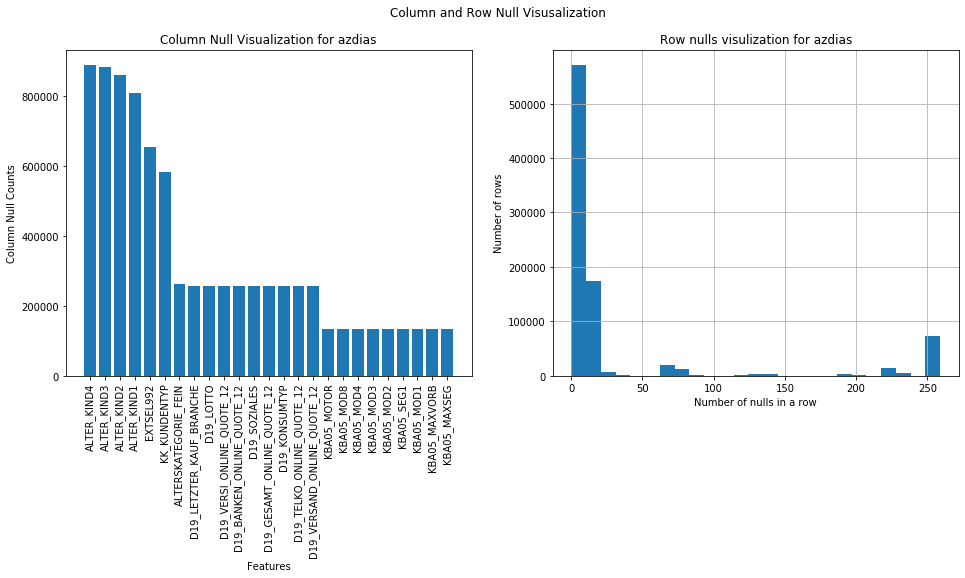

In [53]:
visualize_nulls(azdias_copy,'azdias')

visualize column and row nulls for customer


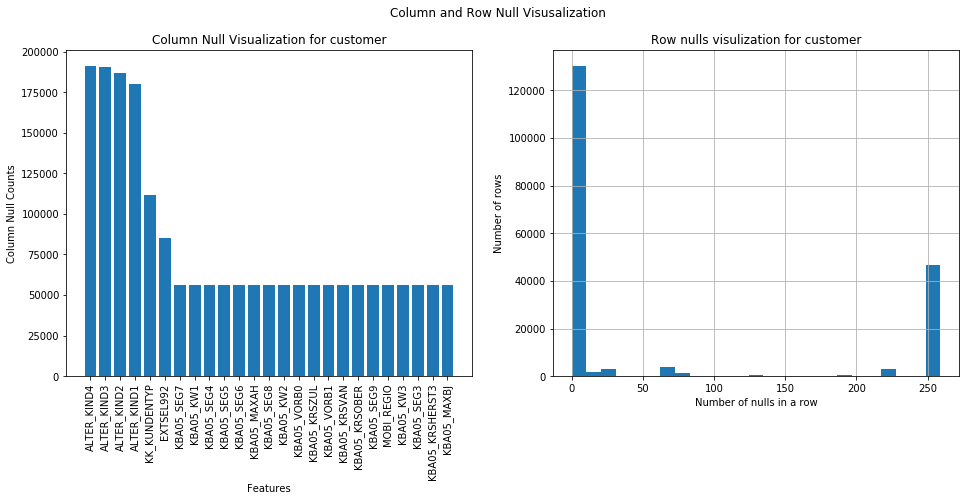

In [54]:
visualize_nulls(customers_copy,'customer')

<b>
<li>The first 6 columns are common in both the dataset having NaN values. I will remove this columns and will impute the others. <li>Also the number of nulls in a row plot, we can see that for both the dataset there are high number of rows having less number of null columns. There are around 70000 rows in azdias and 45000 in customers which have null columns more than 250 in a single row. I will be removing this rows. 
<li> Seeing the plot for number of null columns in a row, the threshold I will be using here is 20. Any row having having 20 or more nulls will be dropped for simplication.

In [55]:
azdias_copy.drop(columns=['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992',
       'KK_KUNDENTYP'],inplace=True)

In [56]:
customers_copy.drop(columns=['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992',
       'KK_KUNDENTYP'],inplace=True)

In [57]:
azdias_copy = azdias_copy[azdias_copy.isnull().sum(axis=1) <= 20].reset_index(drop=True)

In [58]:
azdias_copy.shape

(748746, 360)

In [59]:
customers_copy = customers_copy[customers_copy.isnull().sum(axis=1) <= 20].reset_index(drop=True)

In [60]:
customers_copy.shape

(133690, 363)

<b>First I will convert the category columns and mixed value colums in proper form. I had saved the object type columns into cat_cols list. Will use that list to do further cleaning on category columns

'CAMEO_DEU_2015','CAMEO_DEUG_2015','CAMEO_INTL_2015' have values X or XX. I will convert them to NaN.

In [61]:
print(cat_cols)

['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ', 'PRODUCT_GROUP', 'CUSTOMER_GROUP']


In [62]:
def convert_to_nan(df,col):
    '''
    Dropping columns which are not in metadata
    '''
    if col in set(df_attr_val_level['Attribute']):
        # Replacing XX as NaN
        df[col] = df[col].replace(['X','XX'],np.nan)
    else:
        if col in df.columns:
            df.drop(columns=[col],inplace=True)

In [63]:
for col in cat_cols:
    convert_to_nan(azdias_copy,col)
    convert_to_nan(customers_copy,col)

In [64]:
azdias_copy['CAMEO_DEUG_2015'] = azdias_copy['CAMEO_DEUG_2015'].astype(float)
customers_copy['CAMEO_DEUG_2015'] = customers_copy['CAMEO_DEUG_2015'].astype(float)

In [65]:
"""
Using custom imputer. I first planned to impute with mean values for integer and
float type data, but after looking at data and metadata, 
most of columns are ordinal and wont make sense to impute by mean.
"""
azdias_copy = DataFrameImputer().fit_transform(azdias_copy)

In [66]:
azdias_copy.columns[azdias_copy.isnull().any()]

Index([], dtype='object')

In [67]:
azdias_copy.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,K

In [68]:
customers_copy = DataFrameImputer().fit_transform(customers_copy)

In [69]:
customers_copy.columns[customers_copy.isnull().any()].to_list()

[]

<b>Now, as we have imputed all the null values and clean the data. Lets convert the two categorical columns CAMEO_DEU_2015 and OST_WEST_KZ to numeric by using one hot encoding

In [70]:
azdias_copy = pd.get_dummies(azdias_copy, columns=['CAMEO_DEU_2015','OST_WEST_KZ'])

In [71]:
customers_copy = pd.get_dummies(customers_copy, columns=['CAMEO_DEU_2015','OST_WEST_KZ'])

In [72]:
azdias_copy.shape

(748746, 401)

In [73]:
customers_copy.shape

(133690, 402)

In [74]:
# dropping unwanted columns like LNR 
azdias_copy.drop(columns=['LNR'],inplace=True)

In [75]:
customers_copy.drop(columns=['LNR','ONLINE_PURCHASE'],inplace=True)

<h2> Feature Selection using correlation

In [76]:
corr = azdias_copy.corr()

In [77]:
columns = np.full((corr.shape[0],), True, dtype=bool)

Removing one of the two highly correlated features (https://towardsdatascience.com/feature-selection-correlation-and-p-value-da8921bfb3cf)

In [78]:
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = azdias_copy.columns[columns]


In [79]:
len(selected_columns)

378

In [80]:
with open('selected_columns_corr.pickle', 'wb') as f:
    pickle.dump(selected_columns, f)

In [81]:
#dataframe after selecting columns
cleaned_azdias = azdias_copy.copy()
cleaned_azdias = cleaned_azdias[selected_columns]

In [82]:
cleaned_azdias.shape

(748746, 378)

In [83]:
cleaned_customers = customers_copy.copy()
cleaned_customers = cleaned_customers[selected_columns]

In [84]:
cleaned_customers.shape

(133690, 378)

In [85]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

<b>
I will be using MinMax Scaler on the selected columns. Since we have values that represents a category it seems to be better to us MinMaxScaler as it will transform each value of column to range between 0 and 1. https://benalexkeen.com/feature-scaling-with-scikit-learn/

In [86]:
scaler = MinMaxScaler()

In [87]:
azdias_scaled = pd.DataFrame(scaler.fit_transform(cleaned_azdias),columns=selected_columns)

In [88]:
customers_scaled = pd.DataFrame(scaler.transform(cleaned_customers),columns=selected_columns)


In [89]:
pca = PCA(.95)
azdias_pca = pca.fit(azdias_scaled)

In [90]:
azdias_pca.n_components_

218

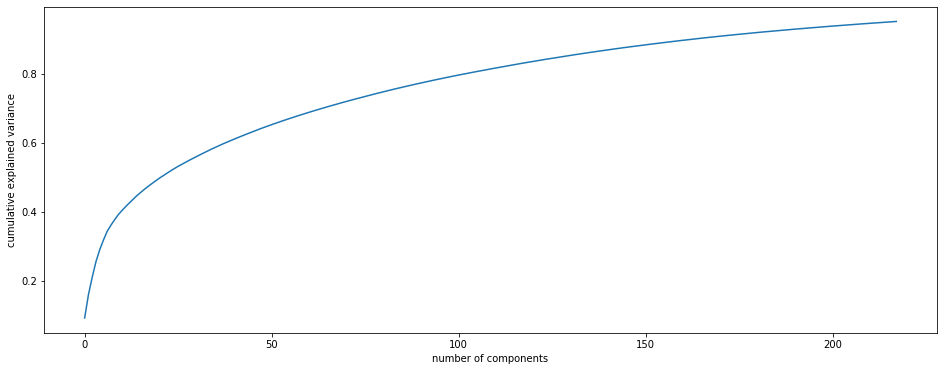

In [91]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

Using Principal Component Analysis, 218 principal components explains about 95 % of the data for general population

In [92]:
# Modified the display_component function from Population segmentation exercise to get the feature weights for components
import seaborn as sns

def display_component(v, features_list, component_num, n_weights=10):
    
    # get index of component (last row - component_num)
    row_idx = component_num - 1

    # get the list of weights from a row in v, dataframe
    v_1_row = v[row_idx]
    v_1 = np.squeeze(v_1_row)

    # match weights to features in counties_scaled dataframe, using list comporehension
    comps = pd.DataFrame(list(zip(v_1, features_list)), 
                         columns=['weights', 'features'])

    # we'll want to sort by the largest n_weights
    # weights can be neg/pos and we'll sort by magnitude
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)

    # display using seaborn
    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component_num))
    plt.show()

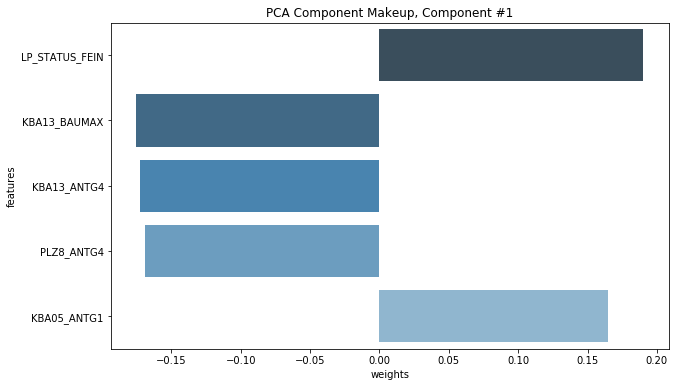

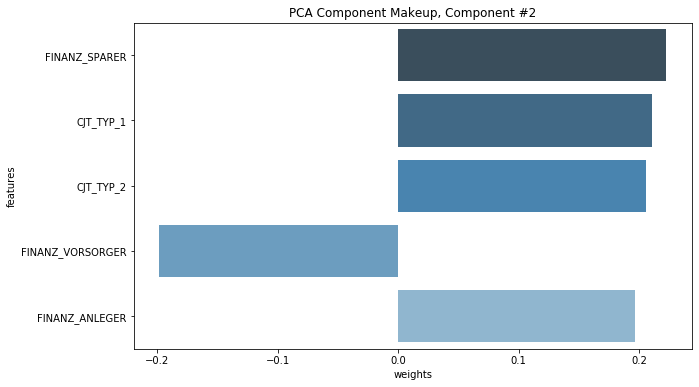

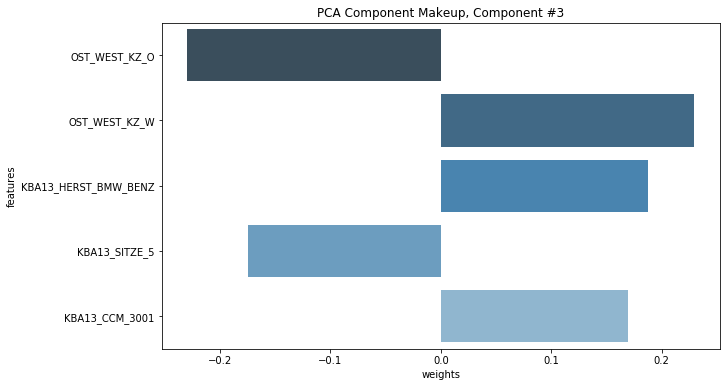

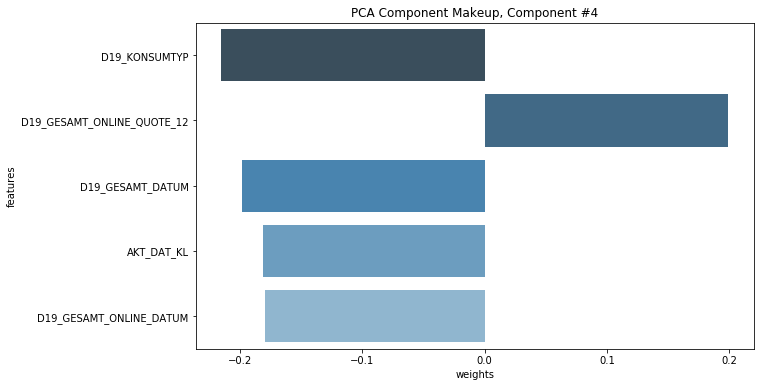

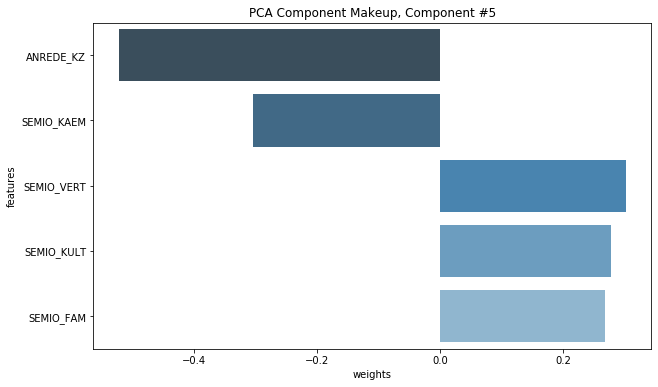

In [93]:
for num in range (1,6):
    display_component(pca.components_, azdias_scaled.columns.values, component_num=num, n_weights=5)

In [94]:
azdias_shrink = pd.DataFrame(pca.transform(azdias_scaled))

In [95]:
azdias_shrink.shape

(748746, 218)

In [96]:
customer_shrink = pd.DataFrame(pca.transform(customers_scaled))

In [97]:
customer_shrink.shape

(133690, 218)

# Clustering

In [98]:
from sklearn.cluster import KMeans,MiniBatchKMeans
# https://towardsdatascience.com/machine-learning-algorithms-part-9-k-means-example-in-python-f2ad05ed5203

In [99]:
%%time
wcss = []
for i in range(1, 20):
    kmeans = MiniBatchKMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0,batch_size=15000)
    kmeans.fit(azdias_shrink)
    wcss.append(kmeans.inertia_)

CPU times: user 3min 51s, sys: 14.7 s, total: 4min 5s
Wall time: 2min 11s


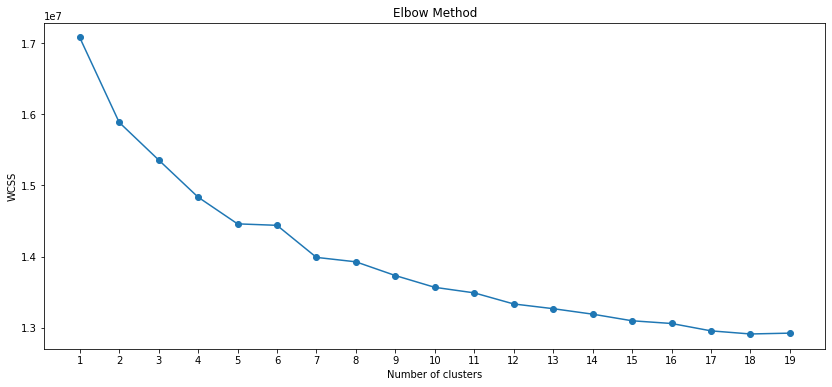

In [100]:
plt.figure(figsize=(14,6))
plt.plot(range(1, 20), wcss,marker='o')
plt.title('Elbow Method')
plt.xticks(list(range(1,20,1)))
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

We want the within cluster sum of squares to be as small as possible as it measures the compactness of the clustering.
We have a knee bend at 5 and 7. We will choose 7 as wcss starts to decrease slowly from this bend.

In [101]:
%%time
km = KMeans(n_clusters=7,random_state=0)
model_kmeans = km.fit(azdias_shrink)
azdias_cluster_predict = model_kmeans.predict(azdias_shrink)

CPU times: user 4min 34s, sys: 12.4 s, total: 4min 47s
Wall time: 4min 37s


In [102]:
customers_cluster_predict = model_kmeans.predict(customer_shrink)

<h3> Analyze the two dataset based on their cluster configuration</h3>
First thing we want to know is how the clusters are represented in both the dataset

In [103]:
azdias_clusters, azdias_clust_counts = np.unique(azdias_cluster_predict, return_counts=True)

In [104]:
customers_clusters, customers_clust_counts = np.unique(customers_cluster_predict, return_counts=True)

In [105]:
representation_stats = pd.DataFrame(columns=['cluster_num','azdias_percentage','customer_percentage','difference','representation'])

In [106]:
representation_stats['cluster_num'] = azdias_clusters

In [107]:
representation_stats['azdias_percentage'] = azdias_clust_counts/np.sum(azdias_clust_counts)*100

In [108]:
representation_stats['customer_percentage'] = customers_clust_counts/np.sum(customers_clust_counts)*100

In [109]:
representation_stats['difference'] = representation_stats['customer_percentage'] - representation_stats['azdias_percentage']

In [110]:
representation_stats['representation'] = representation_stats['difference'].apply(lambda x :'OverRepresentation' if x > 0 else 'UnderRepresentation')

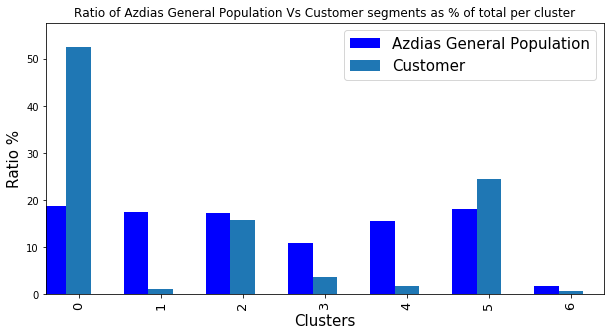

In [111]:
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot()
ax = representation_stats['azdias_percentage'].plot(x=representation_stats['cluster_num'],width=-0.3,align='edge',color='blue',kind='bar',position=0)
ax = representation_stats['customer_percentage'].plot(kind='bar',width = 0.3, align='edge',position=1)
ax.set_xlabel('Clusters', fontsize=15) 
ax.set_ylabel('Ratio %', fontsize=15)
ax.xaxis.set(ticklabels=range(20))
ax.tick_params(axis = 'x', which = 'major', labelsize = 13)
ax.margins(x=0.5,y=0.1)

plt.legend(('Azdias General Population', 'Customer'),fontsize=15)
plt.title(('Ratio of Azdias General Population Vs Customer segments as % of total per cluster'))
plt.show()

Customers in cluster 0 and cluster 5 are over representating the data. The rest clusters are underrepresentating.
Lets check the features in cluster 0 and cluster 1.
Each cluster is representated by 218 PC components. Lets get top features driving this components for cluster 0 and cluster 1

In [112]:
def featuresImpactOnClusters(clusternum):
    weights = model_kmeans.cluster_centers_[clusternum]
    components = list(range(1,219))
    cluster_components = pd.DataFrame({'Weights': weights, 'Component': components})
    cluster_components.sort_values('Weights',ascending=False,inplace = True)
    cluster_components.reset_index(drop=True,inplace=True)
#     print(cluster_components)
    print('First plot - Features from component with positive weight value for cluster ',clusternum)
    component_num =int(cluster_components.iloc[0]['Component'])
#     print(component_num)
    display_component(pca.components_, azdias_scaled.columns.values, component_num=component_num, n_weights=5)
    print('Second plot - Features from component with negative weight value for cluster ',clusternum)
    component_num =int(cluster_components.iloc[217]['Component'])
#     print(component_num)
    display_component(pca.components_, azdias_scaled.columns.values, component_num=component_num, n_weights=5)

First plot - Features from component with positive weight value for cluster  0


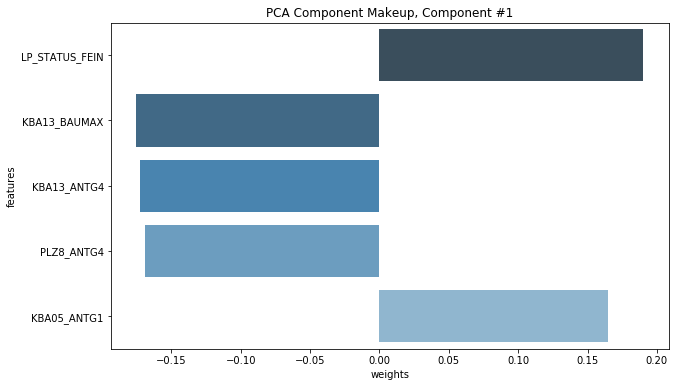

Second plot - Features from component with negative weight value for cluster  0


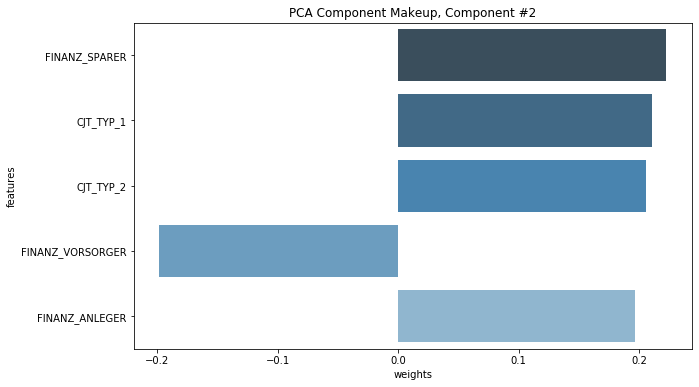

In [113]:
featuresImpactOnClusters(0)

First plot - Features from component with positive weight value for cluster  1


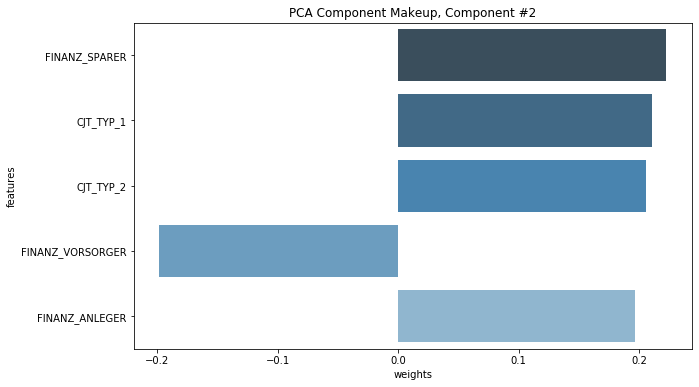

Second plot - Features from component with negative weight value for cluster  1


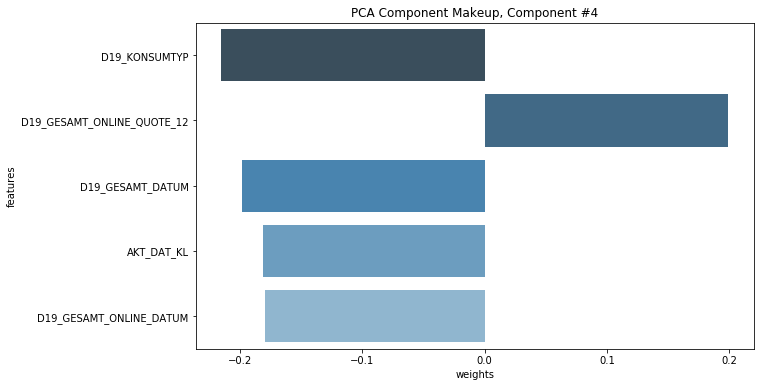

In [114]:
featuresImpactOnClusters(1)

In [115]:
features_in_components_0 = ['LP_STATUS_FEIN','KBA13_BAUMAX','KBA13_ANTG4','PLZ8_ANTG4','KBA05_ANTG1','FINANZ_SPARER',
                          'CJT_TYP_1','CJT_TYP_2','FINANZ_VORSORGER','FINANZ_ANLEGER']

In [116]:
features_in_components_1 = ['FINANZ_SPARER','CJT_TYP_1','CJT_TYP_2','FINANZ_VORSORGER','FINANZ_ANLEGER',
                           'D19_KONSUMTYP','D19_GESAMT_ONLINE_QUOTE_12','D19_GESAMT_DATUM','AKT_DAL_KL','D19_GESAMT_ONLINE_DATUM']

In [117]:
def featureComponentValueMeaning(features_in_components):
    for feature in features_in_components:
        if feature in list(df_attr_val_level['Attribute'].unique()):
            print(feature," -  ",df_attr_val_level[df_attr_val_level['Attribute']==feature]['Description'].drop_duplicates().values[0])
            print("Value Meaning",df_attr_val_level[df_attr_val_level['Attribute']==feature]['Meaning'].drop_duplicates().values)
            print()

In [118]:
featureComponentValueMeaning(features_in_components_0)

LP_STATUS_FEIN  -   social status fine
Value Meaning ['typical low-income earners' 'orientationseeking low-income earners'
 'aspiring low-income earners ' 'villagers'
 'minimalistic high-income earners' 'independant workers'
 'title holder-households' 'new houseowners' 'houseowners' 'top earners ']

PLZ8_ANTG4  -   number of >10 family houses in the PLZ8
Value Meaning ['unknown' 'none' 'low share' 'high share']

KBA05_ANTG1  -   number of 1-2 family houses in the cell
Value Meaning ['unknown' 'no 1-2 family homes' 'lower share of 1-2 family homes'
 'average share of 1-2 family homes' 'high share of 1-2 family homes'
 'very high share of 1-2 family homes']

FINANZ_SPARER  -   financial typology: money saver
Value Meaning ['unknown' 'very high' 'high' 'average' 'low' 'very low']

FINANZ_VORSORGER  -   financial typology: be prepared
Value Meaning ['unknown' 'very high' 'high' 'average' 'low' 'very low']

FINANZ_ANLEGER  -   financial typology: investor
Value Meaning ['unknown' 'very high

In [119]:
featureComponentValueMeaning(features_in_components_1)

FINANZ_SPARER  -   financial typology: money saver
Value Meaning ['unknown' 'very high' 'high' 'average' 'low' 'very low']

FINANZ_VORSORGER  -   financial typology: be prepared
Value Meaning ['unknown' 'very high' 'high' 'average' 'low' 'very low']

FINANZ_ANLEGER  -   financial typology: investor
Value Meaning ['unknown' 'very high' 'high' 'average' 'low' 'very low']

D19_KONSUMTYP  -   consumption type 
Value Meaning ['Universal' 'Versatile' 'Gourmet' 'Family' 'Informed ' 'Modern'
 'Inactive']

D19_GESAMT_ONLINE_QUOTE_12  -   amount of online transactions within all transactions in the complete file 
Value Meaning ['no Online-transactions within the last 12 months'
 '10% Online-transactions within the last 12 months'
 '20% Online-transactions within the last 12 months'
 '30% Online-transactions within the last 12 months'
 '40% Online-transactions within the last 12 months'
 '50% Online-transactions within the last 12 months'
 '60% Online-transactions within the last 12 months'
 '70%

# Analysis and Discussion
<b>
 <li>Customers in Clusters 0 and 5 over-represented the population while clusters 1,2, 3,4, 6 are under-representing the population.
<li>This means the people in cluster 0 and 5 have certain set of features in the principal components which drives that people belonging to this clusters are more likely to be our customers.
<li> As we can see the customers in cluster 0 are driven by features like social status, number of family houses, financially prepared or investor. Few features didn't have information in metadata, hence was not able to describe.
<li>component 2 in both cluster having positive and negative weight impact on cluster 0 and 1 respectively 
<li>Though I was able to get the features driving a cluster, I actually wanted to know which values are actually driving this. Probably an improvement i can work on later sometime!!!

In [120]:
# save models
scaler_model_file = 'saved_models/minmax_scaler.save'
joblib.dump(scaler, scaler_model_file)

pca_model_file = 'saved_models/pca_218.save'
joblib.dump(pca, pca_model_file)

kmeans_model_file = 'saved_models/kmeans_7.save'
joblib.dump(model_kmeans, kmeans_model_file)

['saved_models/kmeans_7.save']

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [121]:
mailout_train = pd.read_csv('arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/Users/admin/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [122]:
mailout_train_copy = mailout_train.copy()

In [123]:
mailout_train_copy.shape

(42962, 367)

In [124]:
# This are the columns that we have to drop and also we will be using the selected_columns from above analysis
# at the cleaning and feature engineering step.
columns_to_drop=['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992',
       'KK_KUNDENTYP']

In [125]:
def dataPreprocess(df):
    df.drop(columns=columns_to_drop,inplace=True)
    
    # Convert values like X,XX in the cat_cols we saw.
    for col in cat_cols:
        convert_to_nan(df,col)
    
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].astype(float)
    df = DataFrameImputer().fit_transform(df)
    # print(df.columns[df.isnull().any()])
    
    df = pd.get_dummies(df, columns=['CAMEO_DEU_2015','OST_WEST_KZ'])

    print(df.shape)
    return df

In [126]:
def selectColumns(df):
    df = df[selected_columns]
    return df

In [127]:
mailout_train_copy = dataPreprocess(mailout_train_copy)

(42962, 402)


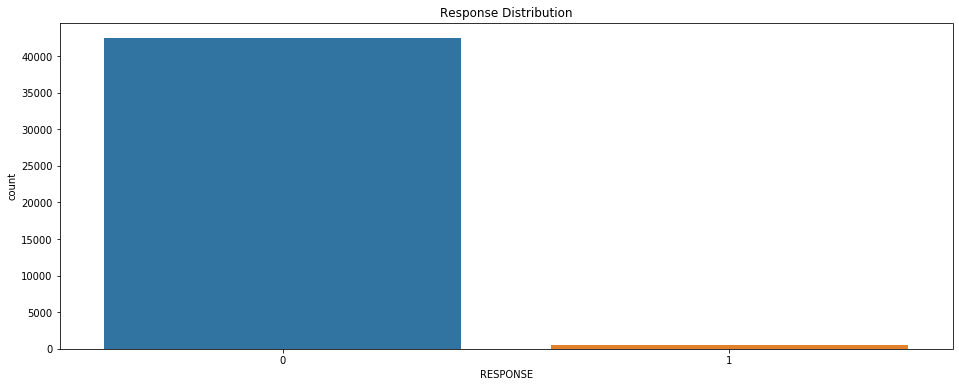

In [128]:
sns.countplot(mailout_train_copy['RESPONSE']).set_title("Response Distribution");

Tried the sampling with 1:1 ration, but the model overfits hence resampling with different ration (1/5)

In [129]:
#Up Sampling
def upSample(df):
    
    df_0 = df[df['RESPONSE'] == 0]
    df_1 = df[df['RESPONSE'] == 1]
    nsample = int(np.floor(len(df_0)/5))
#     print(len(df_0))
#     print(len(df_1))
    df_1_upsampled = resample(df_1,
                                replace=True,    # sample without replacement
                                n_samples=nsample,     # to match majority class
                                random_state=123) # reproducible results
    print("Before Sampling :",df['RESPONSE'].value_counts())
    # Combine two class
    df = pd.concat([df_0, df_1_upsampled])
    # Random shuffle
    df = df.sample(frac=1)
    # Display new class counts
    print("After Sampling :",df['RESPONSE'].value_counts())
    return df

In [130]:
mailout_train_copy = upSample(mailout_train_copy)

Before Sampling : 0    42430
1      532
Name: RESPONSE, dtype: int64
After Sampling : 0    42430
1     8486
Name: RESPONSE, dtype: int64


In [131]:
y = mailout_train_copy['RESPONSE']
X = mailout_train_copy.drop(['LNR','RESPONSE'],axis = 1)

In [132]:
X = selectColumns(X)

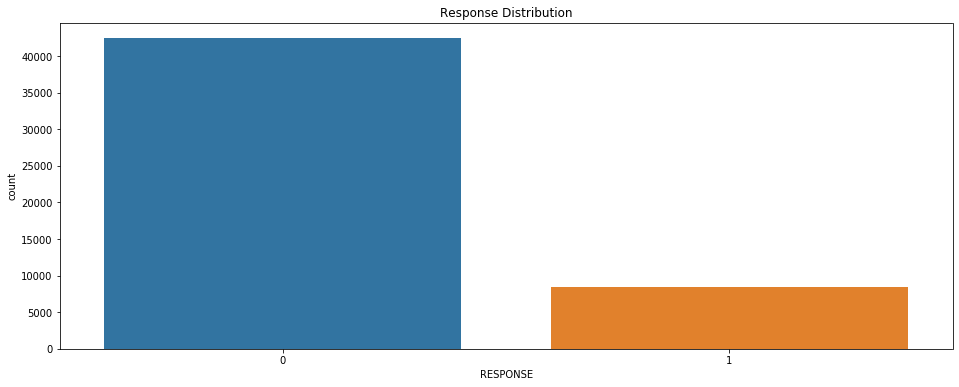

In [133]:
sns.countplot(y).set_title("Response Distribution");

Our class reponse is imbalanced. The accuracy score metrics wont give proper result in this situatio. We will be using ROC AUC metrics for this scenario. Also we will use Stratified Sampling method to get the score
https://machinelearningmastery.com/cross-validation-for-imbalanced-classification/

In [134]:
X = np.array(X)
y= np.array(y)

In [135]:
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold

In [136]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.20,random_state=1)

In [137]:
print(len(X_train)," ",len(X_test))

40732   10184


I have hold out some data 20% of training data to test on the best model. Also since we have less data I will be using KFold crossvalidation using stratified sampling (StratifiedKFold) and plot the roc.

In [138]:
# https://towardsdatascience.com/the-ultimate-guide-to-adaboost-random-forests-and-xgboost-7f9327061c4f

In [139]:
cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)

In [140]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
def train_and_plot_roc(clf,name):
    print(clf)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots()

    for i, (train, test) in enumerate(cv.split(X_train, y_train)):

        clf.fit(X_train[train], y_train[train])
        viz = plot_roc_curve(clf, X_train[test], y_train[test],
                             name='ROC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="Receiver operating characteristic for model {}".format(name))
    ax.legend(loc="lower right")
    plt.show()
    return clf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features=30,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


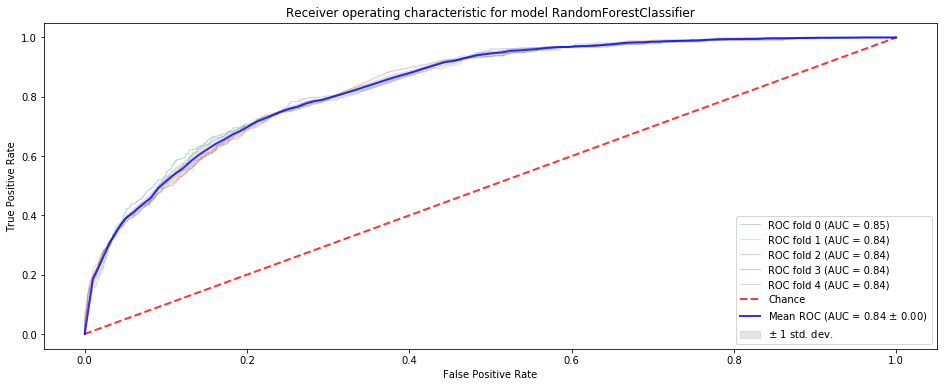

CPU times: user 22.5 s, sys: 245 ms, total: 22.8 s
Wall time: 23 s


In [141]:
%%time
rfc = RandomForestClassifier(max_depth=4,max_features=30,random_state=1)
rfc = train_and_plot_roc(rfc,'RandomForestClassifier')

In [164]:
roc_auc_score(y_test,rfc.predict(X_test))

0.5

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=100, random_state=1)


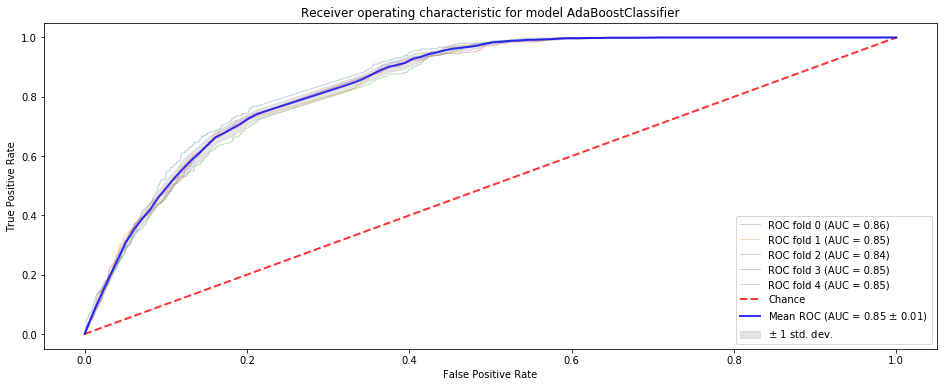

CPU times: user 2min 18s, sys: 3.56 s, total: 2min 22s
Wall time: 2min 29s


In [142]:
%%time
abc = AdaBoostClassifier(random_state=1,n_estimators=100)
abc = train_and_plot_roc(abc,'AdaBoostClassifier')

In [143]:
roc_auc_score(y_test,abc.predict(X_test))

0.6101405463338535

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=30, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=1, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


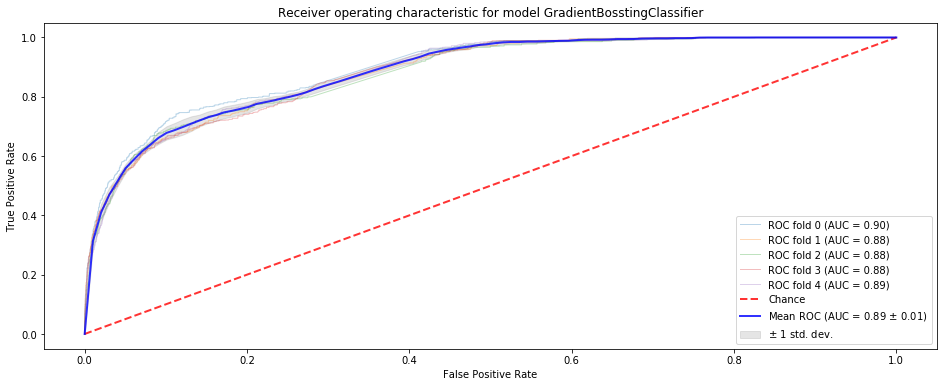

CPU times: user 28.4 s, sys: 447 ms, total: 28.8 s
Wall time: 29.3 s


In [144]:
%%time
gbc = GradientBoostingClassifier(max_features = 30, random_state = 1)
gbc = train_and_plot_roc(gbc,'GradientBosstingClassifier')

In [145]:
roc_auc_score(y_test,gbc.predict(X_test))

0.5469063607906967

<b>The model I used for benchmarking is RandomForestClassifier, where I was able to achieve mean ROC AUC of 0.84 on the StratifiedKfold train set. But performed poorly on validation set.
It seems Adaboost perform better on validation set (X_test) data than the RandomForest and Gradient Boosting Classifier.

In [146]:
param_grid = {'learning_rate': [0.1, 1.0],
             'n_estimators': [50, 100,150]}

grid = GridSearchCV(estimator=AdaBoostClassifier(), param_grid=param_grid, scoring='roc_auc', cv=5)

In [147]:
grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=None,
                                          learning_rate=1.0, n_estimators=50,
                                          random_state=None),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [0.1, 1.0],
                         'n_estimators': [50, 100, 150]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [148]:
grid.best_score_

0.8662491072688321

In [149]:
grid.best_estimator_

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=150, random_state=None)

In [150]:
roc_auc_score(y_test,grid.best_estimator_.predict(X_test))

0.6233987521141383

<b>The ROC AUC value on cross validated data improved, I will be using the model returned by grid search to predict on test data for kaggle. Also the validation set(X_test) that I holded had improvement.

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [151]:
mailout_test = pd.read_csv('arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/Users/admin/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [152]:
mailout_test_copy = mailout_test.copy()

In [153]:
mailout_test_copy.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [154]:
mailout_LNR = mailout_test_copy['LNR']

In [155]:
mailout_test_copy = dataPreprocess(mailout_test_copy)

(42833, 401)


In [156]:
mailout_test_copy = mailout_test_copy[selected_columns]

In [157]:
adb = AdaBoostClassifier(learning_rate=1.0,n_estimators=150, random_state=12)

In [158]:
adb

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=150, random_state=12)

In [159]:
adb.fit(X,y)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=150, random_state=12)

In [160]:
testX = np.array(mailout_test_copy)

In [161]:
preds = adb.predict_proba(testX)

In [162]:
adb.classes_

array([0, 1])

In [163]:
submission = pd.DataFrame({'LNR':mailout_LNR.astype(np.int32), 'RESPONSE':preds[:, 1]})
submission.to_csv('kaggle_submission.csv', index = False)
submission.head()

,LNR,RESPONSE
0,1754,0.499195
1,1770,0.497824
2,1465,0.495293
3,1470,0.495514
4,1478,0.494286


0.71 ROC on Kaggle.

<b>CONCLUSION</b><br>
There is scope for improvement to the model, but this model can we used to predict we if the potential customers will respond to the campaign or not. i.e. If the model thinks they can respond to our campaign then there is no harm in investing our resources to that potential customer. <br>
 <b>Reflection</b>
<li>In this project, I attempted to solve the real world business problem, by creating a machine learning process right from analysing the data, cleaning, imputing, to applying feature reduction techniques like PCA and performing unsupervised learning. Then creating supervised Machine Learning model for predicting whether a potential customer will respond to the campaign and be our customer.
<li>The problem was pretty interesting, but I felt the metadata information was incomplete, and since the field names were in Germany it was a bit difficult in beginning to interpret.
For using the model, i think there is still room for improvements. I will state those in improvements and future work.
    <b>Improvements</b>
<li>The first improvement i would like to do is using one hot encoding on even the features whose values represents certain class of people. There are lot of such ordinal features in the dataset, which are currently treated as numeric values.
<li>Instead of omitting D19_UNBEKANNT and D19_BUCH_CD we could have one hot encoded them. Probably could have some impact as they constitue a good number of data points
<li>Using clustering information as features somehow could provide improvements. I think if the metadata would have been complete it would have helped to for clusters in a better way. The information level in metadata could play a significant role during clustering.
